# Quantum Convolutional Neural Network

## Introduction

This project implements a simplified Quantum Convolutional Neural Network (QCNN), a quantum analogue to a classical convolutional neural network. Convolutional neural networks are used in a variety of application fields, a.o. in remote sensing, which is the classification of satellite images to detect natural phenomena and suspicious activities.

This project follows the work of Iris Cong, Soonwon Choi and Mikhail D Lukin (https://arxiv.org/abs/1810.03787). They showed that this QCNN makes use of only O(log N) parameters for input sizes of N qubits, instead of O(N) parameters in the classical algorithm. This allows for an efficient training and implementation on quantum devices.

This work is also inspired by the implementation of QCNN using the Cirq API, as described in https://www.tensorflow.org/quantum/tutorials/qcnn.

The neural network is translationally invariant and is used to detect certain properties of a quantum data source, such as a quantum sensor or a complex simulation from a device. 

The quantum data source is a cluster state that may or may not have an excitation, which is what the QCNN will learn to detect. The cluster state model is an alternative to the quantum circuit model for the representation of quantum computations. This model is used in the computations in this neural network. The cluster state is highly entangled. The goal of the project is to prepare a cluster state, and to train a quantum classifier to detect if it is "excited" or not. 

Excitations are represented with Rx gates, which represent rotations around the X axis. A large enough rotation is deemed an excitation and is labeled 1 and a rotation that isn't large enough is labeled -1 and deemed not an excitation.

The architecture of the classifier is as follows:

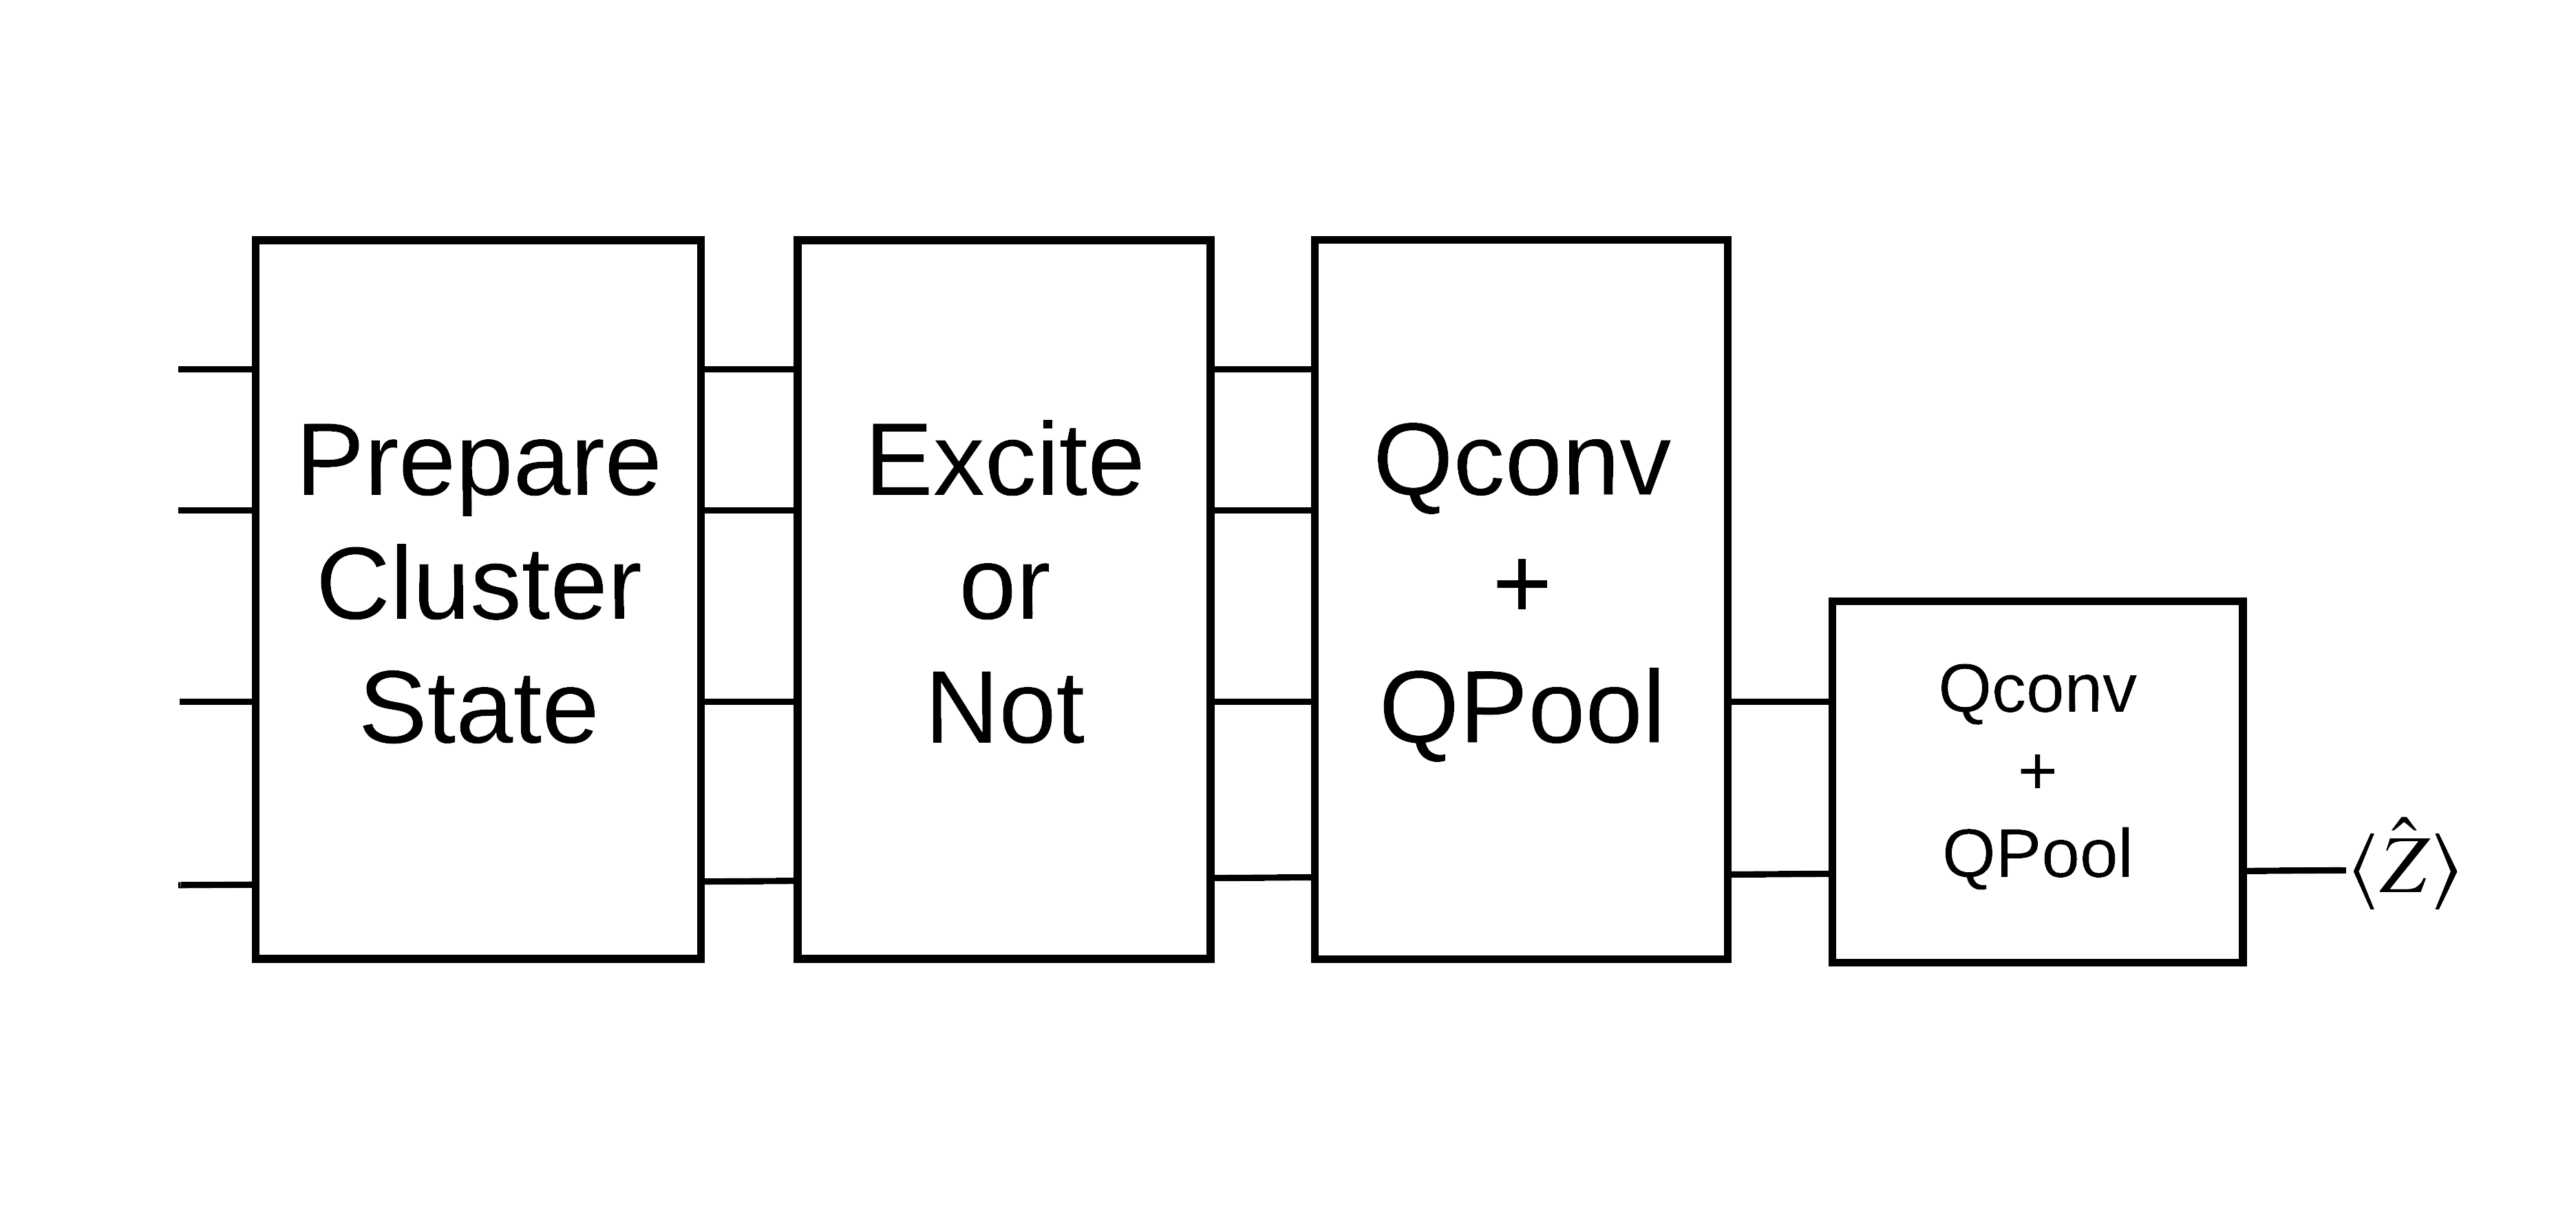

The sequence of layers is:

* Prepare a cluster state
* Check if the cluster state is excited
* Perform a quantum convolution on the cluster state.
* Perform a quantum pooling to reduce the number of qubits. This pooling is attained by reducing the entanglement, so you can pool two qubits into one.
* Perform the previous two steps in a loop, until you only have one qubit left over


## Setup

First import qiskit, numpy and sympy

In [ ]:
import numpy as np
import sympy

# Importing necessary quantum computing library (QISKIT)
import qiskit
from qiskit import transpile, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import *

import torch

## Data generation

Before implementing the layers, we need to generate the data. In this case it's going to be excitations to the cluster state. As mentioned above, excitations are represented with Rx gates, which represent rotations around the X axis. A large enough rotation is deemed an excitation and is labeled 1 and a rotation that isn't large enough is labeled -1 and deemed not an excitation.

In [ ]:

# https://www.tensorflow.org/quantum/tutorials/qcnn
# This function is a readaptation of the tensorflow tutorial using qiskit and pytorch instead
# WARNING: I believe the function is working, but it looks like it is not possible to convert quantum gates
# and quantum circuits to pytorch tensors.
# I don't think there is an equivalent of tfq.convert_to_tensor yet.
# For the moment the function only returns a tuple of lists for train and test excitations.
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 20  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            # Creating a quantum circuit with qiskit
            excitations.append(QuantumCircuit(bit.register).rx(rng, bit.register))
            #excitations.append(cirq.Circuit(cirq.rx(rng)(bit))) / cirq to check if it's correct
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)

    split_ind = int(len(excitations) * 0.7)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]
    
    return train_excitations, np.array(train_labels), \
        test_excitations, np.array(test_labels)


In [ ]:
qr = QuantumRegister(2)
train_excitations, train_labels, test_excitations, test_labels = generate_data(qr)

# Implementation of layers

## Definition of the cluster state

The cluster state model is an alternative to the quantum circuit model for the representation of quantum computations. This model is used in the computations in this neural network. The first step of the computation is to define the cluster state.

In [ ]:
# Source:https://www.tensorflow.org/quantum/tutorials/qcnn
def cluster_state(qr):
    
    qc = QuantumCircuit(qr) # Creating a QuantumRegister
    
    # Applying a Hadamard gate to qubits
    for i, _ in enumerate(qr): 
        qc.h(i)
        
    for this_bit, next_bit in zip(qr, qr[1:] + [qr[0]]):
        c = this_bit.index
        t = next_bit.index
        qc.cz(c, t)
    return qc

In [ ]:
qc_cs = cluster_state(QuantumRegister(4))

In [ ]:
qc_cs.draw('mpl')

## QCNN layers

The quantum convolution and pooling layers of the neural network will be implemented using one-qubit and two-qubit unitary matrices. These unitary matrices are described in a paper by Robert R Tucci (https://arxiv.org/abs/quant-ph/0507171), and are implemented below.

### One Qubit Unitary Matrix

In [ ]:
# Source of the function: https://www.tensorflow.org/quantum/tutorials/qcnn
# The function has been re-adapted for qiskit use
from qiskit.circuit import Parameter
def one_qubit_unitary(bit, rotation=('1', '2', '3')):
    """Make a circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    Parameters
    -----------
    bit: (QuantumRegister (qubit)) 
        qubit that to rotate
    rotation: (tuple) 
        tuple containing the three rotation angle for respectively, x, y and z
    Returns
    -------
        Rotated qubit
    """
    x, y, z = rotation
    qc = QuantumCircuit(bit)
    qc.rx(Parameter(x), 0)
    qc.ry(Parameter(y), 0)
    qc.rz(Parameter(z), 0)
    return qc

In [ ]:
one_qubit_unitary(1, ("e1", "e2", "e3")).draw()

### Two Qubit Unitary Matrix

In [ ]:
# Function still needs some rechecking but it might be correct.
# replace symbols later, still having an issue with symbols
def two_qubit_unitary(bits, 
                      rotations={"q1": ("x1", "y1", "z1"), 
                                "q2": ('x2', 'y2', 'z2'), 
                                "rzyx":("t1", "t2", "t3")}): 
    """Make a qiskit circuit that creates an arbitrary two qubit unitary."""
    
    rot1 = rotations["q1"]
    rot2 = rotations["q2"]
    sub_circ1 = one_qubit_unitary(1, rot1)
    sub_circ2 = one_qubit_unitary(1, rot2)

    qr = bits
    big_qc = QuantumCircuit(qr)
    big_qc.append(sub_circ1.to_instruction(), [qr[0]])
    big_qc.append(sub_circ2.to_instruction(), [qr[1]])
    
    zz, yy, xx = rotations["rzyx"]
    big_qc.rzz(Parameter(zz), 0, 1)
    big_qc.ryy(Parameter(yy), 0, 1)
    big_qc.rxx(Parameter(xx), 0, 1)
    
    big_qc.append(sub_circ1.to_instruction(), [qr[0]])
    big_qc.append(sub_circ2.to_instruction(), [qr[1]])
    
    return big_qc

In [ ]:
two_qubit_unitary(QuantumRegister(2)).decompose().draw('mpl')

### Two Qubit Pooling

This is the operation which attempts to reduce entanglement so we reduce two qubits to one.

In [ ]:
# source: https://www.tensorflow.org/quantum/tutorials/qcnn
def two_qubit_pool(source_qubit, sink_qubit, 
                   rotations={"q1":("x1", "y1", "z1"), 
                              "q2": ("x2", "y2", "z2"), 
                              "invq":("-x", "-y", "-z")}): # add symbols later
    """Make a Qiskit circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    
    rot1 = rotations["q1"]
    rot2 = rotations["q2"]
    sink_basis_selector = one_qubit_unitary(sink_qubit, rot1)
    source_basis_selector = one_qubit_unitary(source_qubit, rot2)
    
    qr = QuantumRegister(2)
    pool_circuit = QuantumCircuit(qr)
    pool_circuit.append(sink_basis_selector.to_instruction(), [qr[0]])
    pool_circuit.append(source_basis_selector.to_instruction(), [qr[1]])
    pool_circuit.cnot(control_qubit=0, target_qubit=1)
    
    # add sink_basis selector I don't know what is being done
    inv_rot = rotations["invq"]
    inv_sink_basis_selector = one_qubit_unitary(source_qubit, inv_rot)
    pool_circuit.append(inv_sink_basis_selector.to_instruction(), [qr[1]])
    
    return pool_circuit

In [ ]:
two_qubit_pool(QuantumRegister(1), QuantumRegister(1)).decompose().draw('mpl')

### Quantum Convolution

The quantum convolution is defined as the application of a two-qubit parameterized unitary to every pair of adjacent qubits with a stride of one.

In [ ]:
def quantum_conv_circuit(bits): # Take care of rotations later
    
    qc = QuantumCircuit(bits)
    # The xyz variable below is meant as a workaround to parameter implementation and replacement
    xyz = ("x", "y", "z")
    k = 0 # variable to increment in order
    
    for first, second in zip(bits[0::2], bits[1::2]):
        i = first.index
        j = second.index
        ### Creating parameters to avoid duplicate names because they raises a Circuit Error ###
        k+=1
        q1_val = tuple([r + str(k) for r in xyz])
        q2_val = tuple([r + str(k + 1) for r in xyz])
        rzyx = tuple([t + str(k) for t in ("theta", "beta", "gamma")])
        k+=1
        rotations = {"q1": q1_val, "q2":q2_val, "rzyx":rzyx}
        qc.append(two_qubit_unitary(QuantumRegister(2), rotations).to_instruction(), [bits[i], bits[j]])
    
    ### Second loop for the second two_qubit unitary
    abc = ("a", "b", "c")
    p = 0
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        i = first.index
        j = second.index
        ### Creating parameters to avoid duplicate names because they raises a Circuit Error ###
        p+=1
        q1_val = tuple([r + str(p) for r in abc])
        q2_val = tuple([r + str(p + 1) for r in abc])
        rzyx = tuple([t + str(p) for t in ("mu", "nu", "eps")])
        p+=1
        rotations = {"q1": q1_val, "q2":q2_val, "rzyx":rzyx}
        qc.append(two_qubit_unitary(QuantumRegister(2), rotations).to_instruction(), [bits[i], bits[j]])
        
    return qc

In [ ]:
quantum_conv_circuit(QuantumRegister(8)).decompose().draw('mpl')

### Quantum Pooling Layer

The quantum pooling layer pools from N qubits to N/2 qubits using the two-qubit pool operation defined above.

In [ ]:
def quantum_pool_circuit(bits):
    
    circuit = QuantumCircuit(bits) # instantiating of the quantum circuit
    # The xyz variable below is mean't as a workaround to parameter implementation and replacement
    xyz = ("x", "y", "z")
    k = 0 # variable to increment in order
    
    assert len(bits) % 2==0, "The number of qubits in the register should be even"
    
    split = len(bits) // 2 # taking half of the quantum register's length

    for source, sink in zip(bits[:split], bits[split:]):
        
        i = source.index # getting source qubit index
        j = sink.index # sink qubit index

        ### Creating parameters to avoid duplicate names because they raises a Circuit Error ###
        k+=1
        q1_val = tuple([r + str(k) for r in xyz])
        invq_val = tuple(["-" + r + str(k) for r in xyz])
        q2_val = tuple([r + str(k + 1) for r in xyz])
        k+=1 # k is incremented twice because q2_val takes the value (k + 1) at k round

        tqb = two_qubit_pool(QuantumRegister(1), QuantumRegister(1), 
                             {"q1": q1_val, "q2":q2_val, "invq":invq_val})
        circuit.append(tqb.to_instruction(),
                       [bits[i], bits[j]])
    return circuit

In [ ]:
test_bits = QuantumRegister(8)
quantum_pool_circuit(test_bits).decompose().draw('mpl')